    В данном ноутбуке будут рассмотрены несколько нейросетей, каждая из которых будет классифицировать изображения рукописных цифр, а последняя будет по изображению числа выдавать его запись. Будут разобрано и продемонстрировано вляние регулярицации на переобучение модели.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from keras.layers import Dense, Conv2D, Dropout, ReLU, Activation, Flatten, MaxPooling2D
from keras.models import Sequential

from keras.datasets import mnist
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import keras


In [6]:

batch_size = 128
num_classes = 10
epochs = 12
img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [12]:
def plot_education(model, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test, train_test_split = 0.25, epochs = 50, callbacks=None):
    history = model.fit(x_train, y_train, validation_split=0.25, epochs=epochs, batch_size=128, verbose=100, callbacks=callbacks)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))    
    fig.suptitle('Metrics comparisson')
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
#     ax1.ylabel('Accuracy')
#     ax1.xlabel('Epoch')
    ax1.set(xlabel='Epochs', ylabel='Accuracy')
    ax1.legend(['Train', 'Test'], loc='upper left')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
#     ax2.ylabel('Loss')
#     ax2.xlabel('Epoch')
    ax2.set(xlabel='Epochs', ylabel='Loss')

    ax2.legend(['Train', 'Test'], loc='upper left')
    
    plt.show()
    on_test = model.evaluate(x_test, y_test, verbose=0)
    print('loss     ---', on_test[0])
    print('accuracy ---', on_test[1])
    return model

Train on 45000 samples, validate on 15000 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.27330, saving model to Model_dense.h5
Epoch 2/30

Epoch 00002: val_loss improved from 0.27330 to 0.21353, saving model to Model_dense.h5
Epoch 3/30

Epoch 00003: val_loss improved from 0.21353 to 0.18846, saving model to Model_dense.h5
Epoch 4/30

Epoch 00004: val_loss did not improve from 0.18846
Epoch 5/30

Epoch 00005: val_loss improved from 0.18846 to 0.16447, saving model to Model_dense.h5
Epoch 6/30

Epoch 00006: val_loss improved from 0.16447 to 0.16065, saving model to Model_dense.h5
Epoch 7/30

Epoch 00007: val_loss improved from 0.16065 to 0.15017, saving model to Model_dense.h5
Epoch 8/30

Epoch 00008: val_loss did not improve from 0.15017
Epoch 9/30

Epoch 00009: val_loss did not improve from 0.15017
Epoch 10/30

Epoch 00010: val_loss improved from 0.15017 to 0.13657, saving model to Model_dense.h5
Epoch 11/30

Epoch 00011: val_loss did not improve from 0.13657
Epoch 1

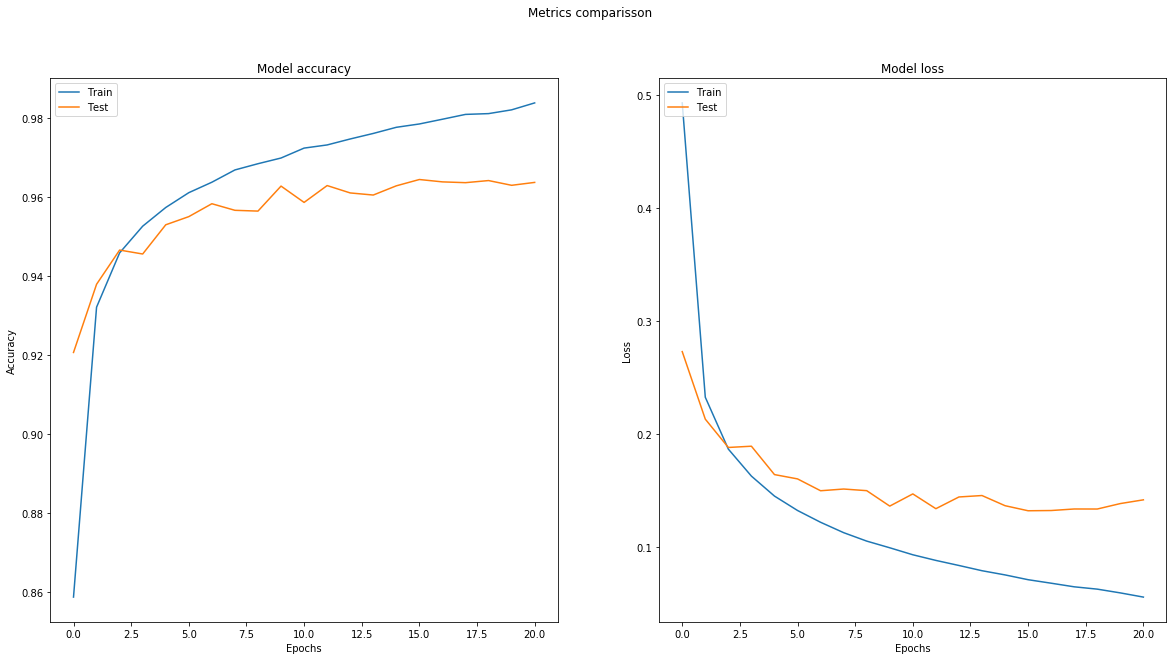

loss     --- 0.11916949233049527
accuracy --- 0.9657999873161316


In [16]:
callbacks = [ModelCheckpoint('Model_dense.h5', verbose=1, save_best_only=True, save_weights_only=False), EarlyStopping(monitor='val_loss', patience=5)]

model = Sequential()
model.add(Flatten())
model.add(Dense(32, activation='relu', input_shape=input_shape))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

plot_education(model, epochs=30, callbacks=callbacks)


Train on 45000 samples, validate on 15000 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.15366, saving model to Model_colv_1_layer.h5
Epoch 2/30

Epoch 00002: val_loss improved from 0.15366 to 0.11256, saving model to Model_colv_1_layer.h5
Epoch 3/30

Epoch 00003: val_loss improved from 0.11256 to 0.09437, saving model to Model_colv_1_layer.h5
Epoch 4/30

Epoch 00004: val_loss improved from 0.09437 to 0.08976, saving model to Model_colv_1_layer.h5
Epoch 5/30

Epoch 00005: val_loss improved from 0.08976 to 0.08370, saving model to Model_colv_1_layer.h5
Epoch 6/30

Epoch 00006: val_loss improved from 0.08370 to 0.07652, saving model to Model_colv_1_layer.h5
Epoch 7/30

Epoch 00007: val_loss improved from 0.07652 to 0.07462, saving model to Model_colv_1_layer.h5
Epoch 8/30

Epoch 00008: val_loss improved from 0.07462 to 0.07356, saving model to Model_colv_1_layer.h5
Epoch 9/30

Epoch 00009: val_loss did not improve from 0.07356
Epoch 10/30

Epoch 00010: val_loss improved

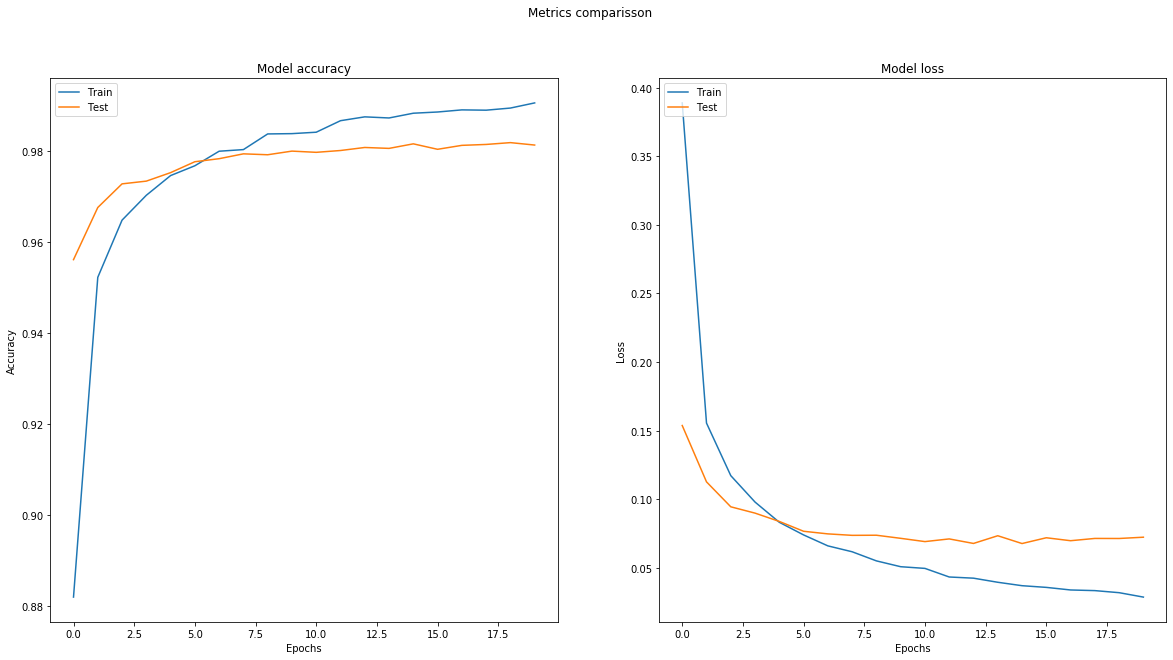

loss     --- 0.053991360007627005
accuracy --- 0.984499990940094


In [17]:
callbacks = [ModelCheckpoint('Model_colv_1_layer.h5', verbose=1, save_best_only=True, save_weights_only=False), EarlyStopping(monitor='val_loss', patience=5)]


model = Sequential()
model.add(Conv2D(filters = 10, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

plot_education(model, epochs=30, callbacks = callbacks)

Train on 45000 samples, validate on 15000 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.11549, saving model to Model_colv_3_layer.h5
Epoch 2/30

Epoch 00002: val_loss improved from 0.11549 to 0.07239, saving model to Model_colv_3_layer.h5
Epoch 3/30

Epoch 00003: val_loss improved from 0.07239 to 0.06025, saving model to Model_colv_3_layer.h5
Epoch 4/30

Epoch 00004: val_loss improved from 0.06025 to 0.06017, saving model to Model_colv_3_layer.h5
Epoch 5/30

Epoch 00005: val_loss did not improve from 0.06017
Epoch 6/30

Epoch 00006: val_loss improved from 0.06017 to 0.04611, saving model to Model_colv_3_layer.h5
Epoch 7/30

Epoch 00007: val_loss did not improve from 0.04611
Epoch 8/30

Epoch 00008: val_loss improved from 0.04611 to 0.03887, saving model to Model_colv_3_layer.h5
Epoch 9/30

Epoch 00009: val_loss did not improve from 0.03887
Epoch 10/30

Epoch 00010: val_loss did not improve from 0.03887
Epoch 11/30

Epoch 00011: val_loss did not improve from 0.03887
E

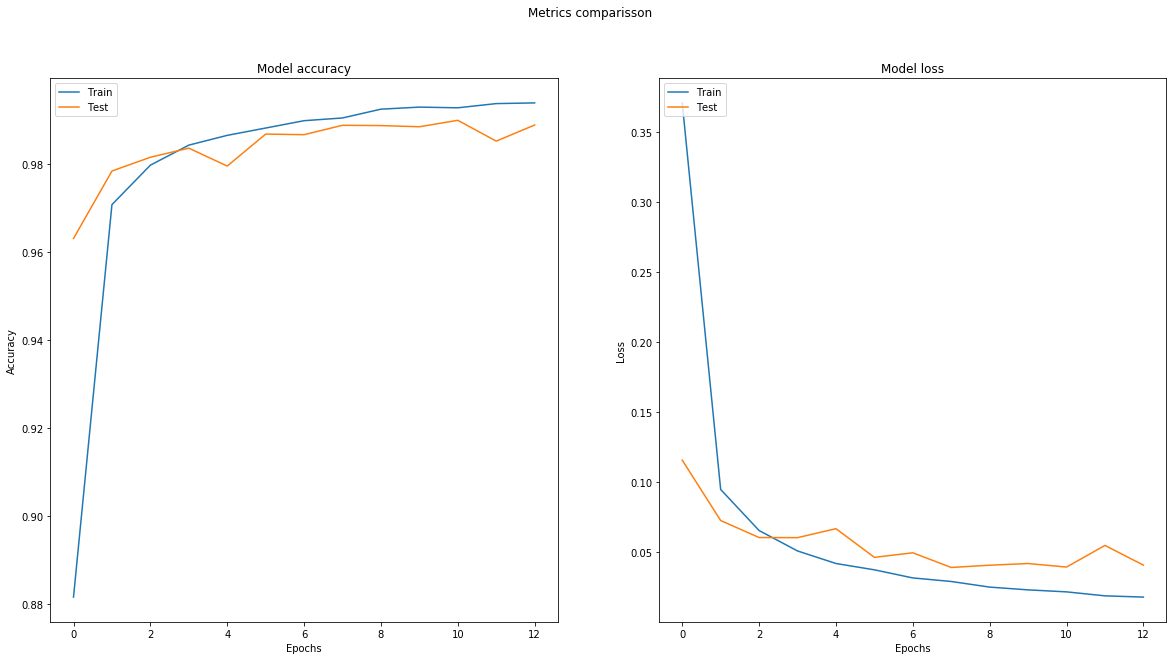

loss     --- 0.027491202508888455
accuracy --- 0.9916999936103821


In [31]:
callbacks = [ModelCheckpoint('Model_colv_3_layer.h5', verbose=1, save_best_only=True, save_weights_only=False), EarlyStopping(monitor='val_loss', patience=5)]


model = Sequential()
model.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D())
model.add(Conv2D(filters = 32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))



model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

best_model = plot_education(model, epochs=30, callbacks=callbacks)

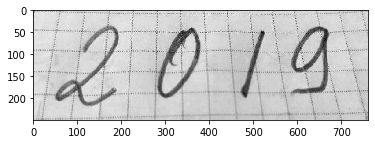

In [133]:
# img = img_to_array(load_img("602.png", color_mode = "grayscale"))
img = img_to_array(load_img("2019.jpg", color_mode = "grayscale"))

plt.imshow(img[..., 0], cmap='gray')

In [137]:
np.argmax(best_model.predict_proba(resize(img[:,:200,:], (28,28))[np.newaxis, ...]))

0

In [135]:
im_h, im_l, _ = img.shape
probs = None
for i in range(0, im_l-im_h):
    sli = img[:, i:i+im_h, 0]
    prob = best_model.predict_proba(resize(sli, (28,28))[np.newaxis, ..., np.newaxis])
    if probs is None:
        probs = prob
    else:
        probs = np.vstack([probs, prob])